# Simplified Plant Growth Model

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from uq_util import *
import matplotlib.pyplot as plt

Platform not recognized, using system temp directory for PCSE settings.
Platform not recognized, using system temp directory for PCSE settings.


In [3]:
plt.rc('font', size=12) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=12) #fontsize of the x and y labels
plt.rc('xtick', labelsize=12) #fontsize of the x tick labels
plt.rc('ytick', labelsize=12) #fontsize of the y tick labels
plt.rc('legend', fontsize=12) #fontsize of the legend

In [4]:
params, wdp, agromanagement = example_wofost_params(verbose=False)
wofost = Wofost71_WLP_FD(params, wdp, agromanagement) #waterlimited production
wofost.run_till_terminate()
output = wofost.get_output()
summary_out = wofost.get_summary_output()
wo_all = WofostOutput(output)


In [5]:
swo = WofostOutput(summary_out)
print(f'{swo.DOS = }')
print(f'{swo.DOE = }')
print(f'{swo.DOA = }')
print(f'{swo.DOM = }')

swo.DOS = array([datetime.date(2000, 5, 15)], dtype=object)
swo.DOE = array([datetime.date(2000, 5, 24)], dtype=object)
swo.DOA = array([datetime.date(2000, 7, 31)], dtype=object)
swo.DOM = array([datetime.date(2000, 9, 18)], dtype=object)


In [6]:
young_mask = (wo_all.day > swo.DOE) & (wo_all.day < swo.DOA)
mature_mask  = (wo_all.day > swo.DOA) & (wo_all.day <= swo.DOM)
pre_mask = (~young_mask & ~mature_mask)

In [7]:
len(output)

141

In [8]:
young_output = np.array(output)[young_mask]
len(young_output)

67

In [9]:
mature_output = np.array(output)[mature_mask]
len(mature_output)

49

In [10]:
pre_output =  np.array(output)[pre_mask] # Pre-emergence output
len(pre_output)

25

In [11]:
assert len(pre_output) + len(mature_output) + len(young_output) == len(output)

In [16]:
params, wdp, agromanagement = example_wofost_params(verbose=False)
wofost = Wofost71_WLP_FD(params, wdp, agromanagement) # water-limited production
wofost.run_till_terminate()
output = wofost.get_output()
summary_out = wofost.get_summary_output()
wo_all = WofostOutput(output[25:])

# Approximate Model

In [12]:
LEVEL = 0.1127 # max assimilation rate is at this level.

def assim_sunlit(AMAX, FGRSH, VISPP, EFF):
#     FGRSUN = AMAX * (1 - (AMAX - FGRSH) * ((1 - np.exp(-VISPP * EFF / AMAX)) / (VISPP * EFF)))
#     FGRSUN = np.where(VISPP <= 0, FGRSH, FGRSUN) # wo_all.FGRSUN
    FGRSUN = AMAX * (1 - (AMAX ) * ((1 - np.exp(-VISPP * EFF / AMAX)) / (VISPP * EFF)))
    FGRSUN = np.where(VISPP <= 0, 0, FGRSUN) # wo_all.FGRSUN
    return FGRSUN

def assim_shaded(VISSHD, EFF):
    FGRSH = VISSHD * EFF 
    return FGRSH
    
def ratio_sunlit(KDIRBL, LAI):
#     FSLLA = np.maximum(0, 1 - LAI * KDIRBL * 0.5) # Approximation by (e^x = 1 + x) near zero.
#     k = KDIRBL * level
#     f = lambda a: np.exp(-k * a)
#     f_prime = lambda a: -k * np.exp(-k * a)
#     a = 0.5
#     approx = f(a) + f_prime(a) * (LAI - a)

#     approx = 1 - 1./7 * LAI 
#     approx = np.ones(len(LAI))
#     approx[25:] = 0.1
    approx = .5
    FSLLA = np.maximum(0, approx) # Approximation by (e^x = 1 + x) near zero.
    return FSLLA

def leaf_area_index(SLAT, TWLV):
    return SLAT * TWLV
    
def light_sun(VISPP):
    return VISPP

def light_shaded(KDIF, PARDIF, LAI, level):
    k = KDIF * level
    f = lambda x: np.exp(-k * x)
    f_prime = lambda x: -k * np.exp(-k * x)
    a = (max(LAI) - min(LAI)) / 2
#     print(f_prime(a))
    approx = f(a) + f_prime(a) * (LAI - a)
    VISSHD = PARDIF * KDIF * approx # Without (1 - REFS) because we don't consider the VIST or VISD
    # VISSHD decreases in time.
#     plt.figure()
#     plt.title('VISSHD')
#     plt.plot(VISSHD)
#     plt.plot(wo_all.VISSHD)
#     plt.show()

    plt.plot()
    return VISSHD
    
def unit_assim(FSLLA, FGRSUN, FGRSH):
    FGL = FSLLA * FGRSUN + (1 - FSLLA) * FGRSH
    return FGL

def approx_simulation(wo, level=LEVEL):
    LAI =  leaf_area_index(wo.SLAT, wo.TWLV) # Here TWLV needs to be our computed Weight! 
    VISSHD = light_shaded(wo.KDIF, wo.PARDIF, LAI, level)
    FGRSH = assim_shaded(VISSHD, wo.EFF)
    FGRSUN = assim_sunlit(wo.AMAX, FGRSH, wo.VISPP, wo.EFF)
    FSLLA = ratio_sunlit(wo.KDIRBL, LAI)
    FGL = unit_assim(FSLLA, FGRSUN, FGRSH)
    return FGL

In [13]:
params, wdp, agromanagement = example_wofost_params(verbose=False)
wofost = Wofost71_WLP_FD(params, wdp, agromanagement) # water-limited production
wofost.run_till_terminate()
output = wofost.get_output()
summary_out = wofost.get_summary_output()
wo_all = WofostOutput(output[25:])

In [27]:
# plt.plot(wo_all.FSLLA) # level=0

In [28]:
# plt.plot(wo_all.FSLLA) #level=1

In [29]:
# wo_all.SINB

In [30]:
# wo_all.SINB

In [31]:
# wo_all.PARDIR

In [32]:
# wo_all.PREFGROS

In [33]:
# wo_all.FGROS

In [34]:
# wo_all.WMAX_FGL

In [35]:
# wo_all.WMAX_L

<ipython-input-12-e133439e5169>:6: RuntimeWarning: invalid value encountered in true_divide
  FGRSUN = AMAX * (1 - (AMAX ) * ((1 - np.exp(-VISPP * EFF / AMAX)) / (VISPP * EFF)))
<ipython-input-12-e133439e5169>:6: RuntimeWarning: invalid value encountered in true_divide
  FGRSUN = AMAX * (1 - (AMAX ) * ((1 - np.exp(-VISPP * EFF / AMAX)) / (VISPP * EFF)))


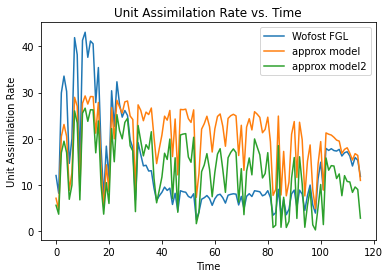

In [14]:
plt.plot(wo_all.FGL, label='Wofost FGL') # unit assim rate at level=L
# plt.plot(wo_all.PREFGROS, label='PREFGROS') # average over the levels
unit_assim_rate = approx_simulation(wo_all) # at level L.
plt.plot(unit_assim_rate, label='approx model') 
unit_assim_rate2 = approx_simulation(wo_all, level=0.5) # at level L.
plt.plot(unit_assim_rate2, label='approx model2') 
plt.xlabel('Time')
plt.title('Unit Assimilation Rate vs. Time')
plt.ylabel('Unit Assimilation Rate')
plt.legend()
plt.show()

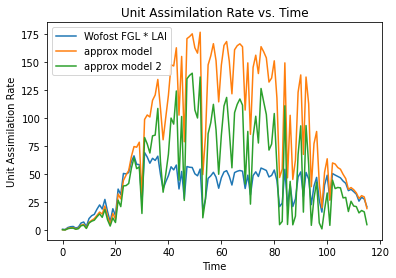

In [15]:
# plt.plot(wo_all.FGROS, label='Wofost FGROS') # average over the levels
plt.plot(wo_all.FGL * wo_all.LAI, label='Wofost FGL * LAI') # unit assim rate at level=L
plt.plot(unit_assim_rate * wo_all.LAI, label='approx model') 
plt.plot(unit_assim_rate2 * wo_all.LAI, label='approx model 2') 

plt.xlabel('Time')
plt.title('Unit Assimilation Rate vs. Time')
plt.ylabel('Unit Assimilation Rate')
plt.legend()

In [16]:
# plt.scatter(wo_all.LAI, wo_all.FSLLA, label='Wofost FSLLA')
# plt.scatter(wo_all.LAI, ratio_sunlit(wo_all.KDIRBL, wo_all.LAI), label='approx') # unit assim rate at level=L
# plt.scatter(wo_all.LAI, ratio_sunlit(wo_all.KDIRBL, leaf_area_index(wo_all.SLAT, wo_all.TWLV)), label='approx') # unit assim rate at level=L

# plt.legend()
# plt.xlabel('LAI')
# plt.show()
# plt.plot(wo_all.FSLLA, label='Wofost FSLLA') # unit assim rate at level=L
# plt.plot(ratio_sunlit(wo_all.KDIRBL, wo_all.LAI), label='approx') # unit assim rate at level=L
# plt.plot(ratio_sunlit(wo_all.KDIRBL, leaf_area_index(wo_all.SLAT, wo_all.TWLV)), label='approx') # unit assim rate at level=L
# plt.xlabel('Time')

In [17]:
# wo_all.WMAXFGROS #
# wo_all.MAXFGROS_I # 0
# wo_all.MAX_L # 0 
# wo_all.WMAX_L # 1, 1, ..., 0, ......... 0

In [18]:
#  # unit assim rate at level=0, hour=0
# # plt.plot(wo_all.MAXFGROS, label='Wofost MAXFGROS')
# plt.plot(wo_all.FGL * wo_all.LAI, label='Wofost FGL*LAI') # --> highest!
# plt.plot(wo_all.PREFGROS * wo_all.LAI, label='Wofost PREFGROS*LAI') # = FGROS
# plt.plot(wo_all.FGROS, label='Wofost FGROS')

# # plt.plot(wo_all.FGROS * wo_all.LAI, label='Wofost 2')
# # plt.plot(wo_all.DTGA, label='Wofost DTGA')

# LAI = leaf_area_index(wo_all.SLAT, wo_all.TWLV)
# # plt.plot(unit_assim_rate * wo_all.LAI, label='approx model')
# # plt.plot(unit_assim_rate * LAI, label='approx model')

# plt.xlabel('Time')
# plt.title('Unit Assimilation Rate vs. Time')
# plt.ylabel('Unit Assimilation Rate')
# plt.legend()

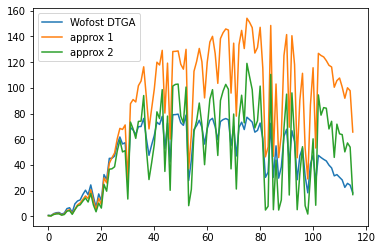

In [19]:
# plt.plot(wo_all.MAXFGROS , label='Wofost MAXFGROS') # --> want to model this
# FGL at max level is logged, but at every hour. So only hour=3 FGL is logged in real.
# That's why FGL * LAI looks less than MAXFGROS. 
# plt.plot(wo_all.FGL * wo_all.LAI, label='Wofost FGL*LAI') 
plt.plot(wo_all.DTGA, label='Wofost DTGA')
# DTGA is less than MAXFGROS because it's an average. 
# Now, try to use unit_assim_rate instead of FGL. 
# plt.plot(unit_assim_rate * wo_all.LAI, label='approx 1') 
plt.plot(unit_assim_rate * leaf_area_index(wo_all.SLAT, wo_all.TWLV), label='approx 1') 
plt.plot(unit_assim_rate2 * leaf_area_index(wo_all.SLAT, wo_all.TWLV), label='approx 2') 

plt.legend()

In [20]:
def get_gass(wo, level=LEVEL):
    LAI = leaf_area_index(wo.SLAT, wo.TWLV)
    CR = 30./44. # conversion coefficient (from chemical equation)
    unit_assim_rate = approx_simulation(wo, level)
    GASS = wo.RFTRA * CR * wo.DAYL * LAI * unit_assim_rate
    return GASS 

<ipython-input-12-e133439e5169>:6: RuntimeWarning: invalid value encountered in true_divide
  FGRSUN = AMAX * (1 - (AMAX ) * ((1 - np.exp(-VISPP * EFF / AMAX)) / (VISPP * EFF)))
<ipython-input-12-e133439e5169>:6: RuntimeWarning: invalid value encountered in true_divide
  FGRSUN = AMAX * (1 - (AMAX ) * ((1 - np.exp(-VISPP * EFF / AMAX)) / (VISPP * EFF)))


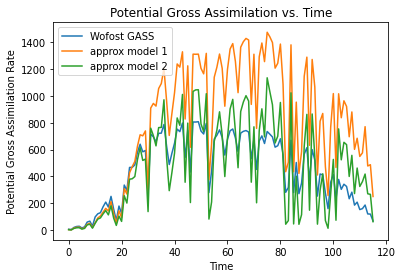

In [21]:
plt.plot(wo_all.GASS, label='Wofost GASS')
plt.plot(get_gass(wo_all, level=0.11), label='approx model 1')
plt.plot(get_gass(wo_all, level=.5), label='approx model 2')

plt.xlabel('Time')
plt.title('Potential Gross Assimilation vs. Time')
plt.ylabel('Potential Gross Assimilation Rate')
plt.legend()

In [292]:
# plt.plot(np.diff(wo_all.SLAT))
# plt.plot(wo_all.SLAT)

In [ ]:

# def old_explicit_solution(CVF, W0, f, r):
#     # Explicit Solution
#     q = CVF * (f - r)
#     integral = q.cumsum()
#     w = W0 * np.exp(integral)
#     # plt.plot(integral)
#     return w

# def explicit_solution(CVF, W0, f, g, r):
#     # Explicit Solution
#     q = CVF * (f - r)
#     # Make sure respiration is not greater than assimilation
#     q = np.minimum(0, q)
#     g = CVF * g
    
#     int_q = q.cumsum()
#     temp = np.zeros(len(q))
#     for z in range(len(q)):
#         temp[z] = np.exp(-int_q[z]) *  g[z]
#     int_z = temp.cumsum()
#     w = W0 * np.exp(int_q) + np.exp(int_q) * int_z
#     return w


In [25]:
np.random.seed(42)
## Version April 22, 2021
LEVEL = 0.5
eps = 1e-6
def pf(plant_organ, wo):
    if plant_organ == 'root':
        return wo.FR
    if plant_organ == 'leaf':
        return wo.FL * (1 - wo.FR)
    if plant_organ == 'stem':
        return wo.FS * (1 - wo.FR)
    if plant_organ == 'storage':
        return wo.FO * (1 - wo.FR)
    else:
        return None 
    
def get_pf_correction(plant_organ, wo):
    '''Very hacky way of correcting the partitioning factor'''
    wo_weight = (wo.TWRT + wo.TAGP)
    derv = np.zeros(len(wo_weight))
    derv[1:] = np.diff(pf(plant_organ, wo))
    int_derv = (derv * wo_weight).cumsum()
    coef_cor = int_derv / wo_weight
    return coef_cor

def new_pf(plant_organ, wo):
    '''Subtract the correction term.'''
    return pf(plant_organ, wo) - get_pf_correction(plant_organ, wo)
    
def coef_resp(wo):
    coef_r = wo.RMR * new_pf('root', wo)
    coef_l = wo.RML * new_pf('leaf', wo)
    coef_s = wo.RMS * new_pf('stem', wo)
    coef_o = wo.RMO * new_pf('storage', wo)
    coef_res = coef_r + coef_l + coef_s + coef_o
    return wo.RFSETB * wo.TEFF * coef_res

def coef_new_LAI(wo):
    '''
    LAI = SLAT * W_leaf
    W_leaf = p_leaf * W 
    '''
    return wo.LAI / (wo.TAGP + wo.TWRT) 
#     return wo.SLAT * new_pf('leaf', wo)

def coef_LAI(wo):
    '''
    LAI = SLAT * W_leaf
    W_leaf = p_leaf * W 
    '''
#     return wo.LAI / (wo.TAGP + wo.TWRT) 
    return wo.SLAT * pf('leaf', wo)

def coef_assim_sunlit(wo):
    '''Underestimate FGRSUN a little bit because on cloudy days'''
    VISPP = np.where(wo.VISPP <= 0, eps, wo.VISPP)
    FGRSUN = wo.AMAX * (1 - (wo.AMAX ) * ((1 - np.exp(-VISPP * wo.EFF / wo.AMAX)) / (VISPP * wo.EFF)))
    FGRSUN = np.where(wo.VISPP <= 0, 0, FGRSUN) # should be FGRSH instead of 0.
#     return wo.FGRSUN
    return FGRSUN

def coef_assim_shaded(wo, level=LEVEL):
    a = 3.0 # Magic Number - Median of LAI, best place for approximation of exp
    k = wo.KDIF * level
    func = lambda x: np.exp(-k * x)
    f_prime = lambda x: -k * np.exp(-k * x)
    const = wo.PARDIF * wo.KDIF * (func(a) - f_prime(a) * a)
#     plt.title('Shaded const')
#     plt.plot(const) # positive
    coef = wo.PARDIF * wo.KDIF * f_prime(a)
#     plt.plot(coef) # Negative: Makes VISSHD decrease
    # Multiply by (1-rho)
#     const *= (1-wo.REFS)
#     coef *= (1-wo.REFS)
    return const, coef
    
def get_f_and_g(wo):
    FSLLA = 0.5 #0.1
    sunny_const = coef_assim_sunlit(wo)
    shaded_const, shaded_coef = coef_assim_shaded(wo)
    # constant term from shaded + sunlit
    g = FSLLA * sunny_const + (1 - FSLLA) * wo.EFF * shaded_const 
    # coef of weight from the shaded leaves term
    f = (1 - FSLLA) * wo.EFF * shaded_coef 
#     plt.plot(shaded_coef * weight + shaded_const)
    #     plt.plot(f*wo_all.TAGP)
    return f, g

def get_k(wo):
    CR = 30./44.
    return wo.RFTRA * CR * wo.DAYL

def solution_sq(CVF, C0, f, g, r, k, l, q_noisy=False, y_noisy=False):
    N = len(f)
    assim1 = g * k * l # * W
    assim2 = f * k * l**2 # * W^2

    q = assim2 * CVF # coefficent of the second order term
    if q_noisy:
#         plt.plot(q, label='q')
#         plt.title('q')
        q_err = 1e-6 #q.std()
        print(f'{q_err = }')
        noise = np.random.normal(0, q_err, N)
        q += noise
#         plt.plot(q, label='noisy q')
#         plt.show()
    
    y = np.maximum(0, assim1 - r) * CVF # coefficent of the first order term
    if y_noisy:
        y_err = 0.001 #y.std()
        print(f'{y_err = }')
        noise = np.random.normal(0, y.std(), N)
        y += noise
    
    int_y = y.cumsum()
    print(f'{int_y[0] = }')
    
    temp = np.zeros(N)
    for z in range(N):
        temp[z] = np.exp(int_y[z]) *  q[z]
    int_z = temp.cumsum()
    print(f'{int_z[0] = }')
#     (C0 - int_z[0]) * W0 = int_y[0]
#     C0 = int_y[0] / W0 + int_z[0]
    W = np.exp(int_y) / (C0 - int_z)
    return W

# def solution_sq(CVF, C0, f, g, r, k):
#     q = f * k * CVF # coefficent of the second order term
#     y = np.maximum(0, g * k - r) * CVF # coefficent of the first order term
#     int_y = y.cumsum()
    
#     temp = np.zeros(len(y))
#     for z in range(len(y)):
#         temp[z] = np.exp(-int_y[z]) *  q[z]
#     int_z = temp.cumsum()
    
#     W = np.exp(int_y) / (C0 - int_z)
#     return W

def derv_pf(organ, wo):
    return np.diff(pf(organ, wo), prepend=pf(organ, wo)[0])

def partition_organ(organ, W, wo):
    return pf(organ, wo) * W - (W * derv_pf(organ, wo)).cumsum()

In [26]:
# l = coef_LAI(wo_all)
# f, g = get_f_and_g(wo_all)
# r = coef_resp(wo_all)
# k = get_k(wo_all)
# W0 = wo_all.TWRT[0] + wo_all.TWLV[0] + wo_all.TWSO[0] + wo_all.TWST[0] 
# print("Initial weight at emergence:", W0)
# C0 = 1. / W0
# W = solution_sq(wo_all.CVF, C0, f, g, r, k, l)
# plt.figure(figsize=(10, 6))
# plt.plot(wo_all.TAGP + wo_all.TWRT, label='Wofost')
# plt.plot(W, label='Simple Model')
# plt.ylabel('Total Plant Weight')
# plt.xlabel('Days since emergence')
# plt.title('Plant Growth')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# organs = ['root', 'leaf', 'stem', 'storage']
# colors = ['blue', 'green', 'magenta', 'red']
# for i in range(len(organs)):
#     organ = organs[i]
#     plt.plot(true_weights[i], label=f'Wofost {organ}', color=colors[i], alpha=0.5)
#     plt.plot(partition_organ(organ, W, wo_all), label=f'approx. {organ}', color=colors[i], linestyle='dashed')
# plt.title('Partitioning of the simulated weight')
# plt.legend()
# plt.show()

In [29]:
# plt.plot(wo_all.REFS)

Initial weight at emergence: 79.92969115418717
int_y[0] = 0.028160915513340937
int_z[0] = -5.131401982710964e-06
W[0]=82.17887187754756


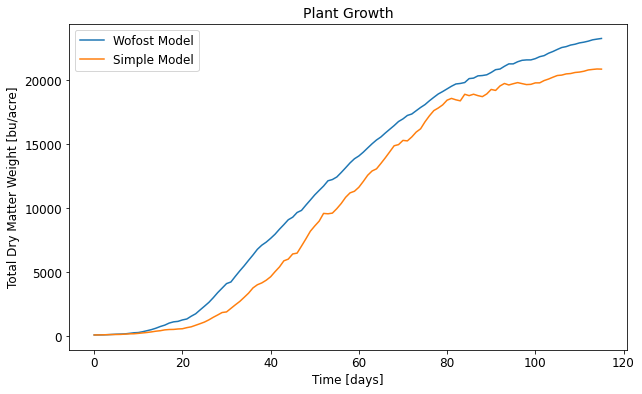

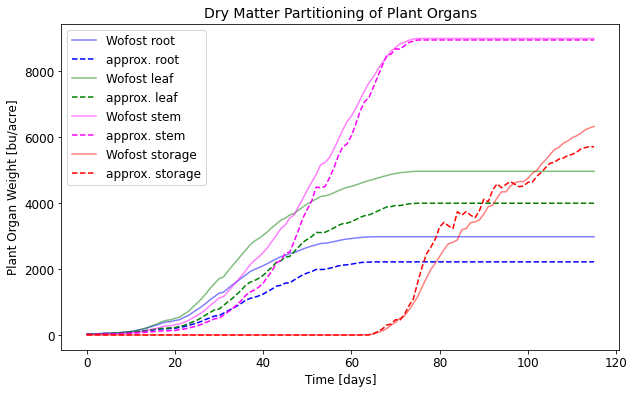

In [28]:
l = coef_new_LAI(wo_all)
f, g = get_f_and_g(wo_all)
r = coef_resp(wo_all)
k = get_k(wo_all)
W0 = wo_all.TWRT[0] + wo_all.TWLV[0] + wo_all.TWSO[0] + wo_all.TWST[0] 
print("Initial weight at emergence:", W0)
C0 = 1. / W0
W = solution_sq(wo_all.CVF, C0, f, g, r, k, l)
print(f'{W[0]=}')
total_weight = wo_all.TAGP + wo_all.TWRT
plt.figure(figsize=(10, 6))
plt.plot(total_weight, label='Wofost Model')
plt.plot(W, label='Simple Model')
plt.ylabel('Total Dry Matter Weight [bu/acre]')
plt.xlabel('Time [days]')
plt.title('Plant Growth')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
organs = ['root', 'leaf', 'stem', 'storage']
colors = ['blue', 'green', 'magenta', 'red']
true_weights = [wo_all.TWRT, wo_all.TWLV, wo_all.TWST, wo_all.TWSO]
total_weight = (wo_all.TAGP + wo_all.TWRT)
for i in range(len(organs)):
    organ = organs[i]
    plt.plot(true_weights[i], label=f'Wofost {organ}', color=colors[i], alpha=0.5)
    plt.plot(partition_organ(organ, W, wo_all), label=f'approx. {organ}', color=colors[i], linestyle='dashed')
plt.title('Dry Matter Partitioning of Plant Organs')
plt.ylabel('Plant Organ Weight [bu/acre]')
plt.xlabel('Time [days]')
plt.legend()
plt.show()

Initial weight at emergence: 79.92969115418717
int_y[0] = 0.028160915513340937
int_z[0] = -5.131401982710964e-06
W[0]=82.17887187754756


Text(0.5, 1.0, 'Plant Growth')

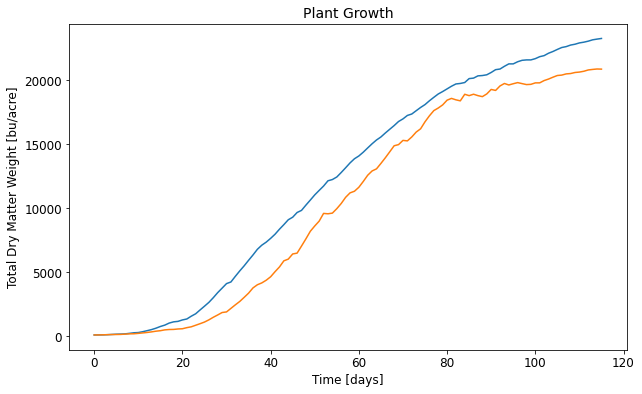

In [113]:
%matplotlib inline
l = coef_new_LAI(wo_all)
f, g = get_f_and_g(wo_all)
r = coef_resp(wo_all)
k = get_k(wo_all)
W0 = wo_all.TWRT[0] + wo_all.TWLV[0] + wo_all.TWSO[0] + wo_all.TWST[0] 
print("Initial weight at emergence:", W0)
C0 = 1. / W0
W = solution_sq(wo_all.CVF, C0, f, g, r, k, l)
print(f'{W[0]=}')
plt.figure(figsize=(10, 6))
plt.plot(total_weight, label='Wofost Model')
plt.plot(W, label='Simple Model')
plt.ylabel('Total Dry Matter Weight [bu/acre]')
plt.xlabel('Time [days]')
plt.title('Plant Growth')
# W = solution_sq(wo_all.CVF, C0, f, g, r, k, l, q_noisy=True, y_noisy=False)
# plt.plot(W, label='noisy q')
# W = solution_sq(wo_all.CVF, C0, f, g, r, k, l, q_noisy=False, y_noisy=True)
# plt.plot(W, label='noisy y')
# W = solution_sq(wo_all.CVF, C0, f, g, r, k, l, q_noisy=True, y_noisy=True)
# plt.plot(W, label='noisy q and y')
# plt.legend()
# plt.show()

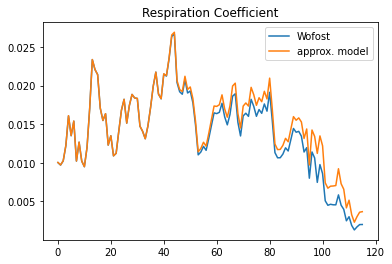

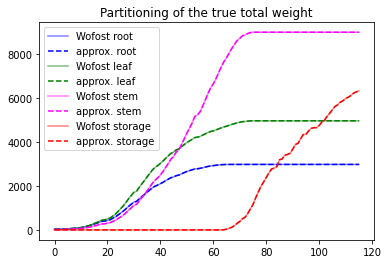

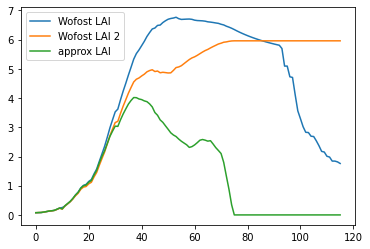

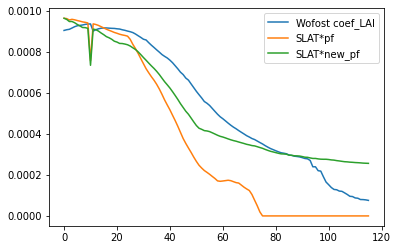

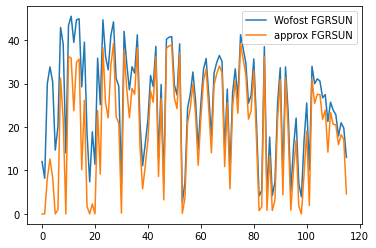

In [88]:
# Simple Tests:
# Check Maintenance Respiration coefficient r:
plt.plot(wo_all.MRES / (wo_all.TAGP + wo_all.TWRT), label='Wofost')
plt.plot(r, label='approx. model')
plt.legend()
plt.title('Respiration Coefficient')
plt.show()

# Check partitioning coefficient new_pf
for i in range(len(organs)):
    organ = organs[i]
    plt.plot(true_weights[i], label=f'Wofost {organ}', color=colors[i], alpha=0.5)
    plt.plot(total_weight * new_pf(organ, wo_all), label=f'approx. {organ}', color=colors[i], linestyle='dashed')
plt.title('Partitioning of the true total weight')
plt.legend()
plt.show()
assert sum([new_pf(i, wo_all) for i in organs]).all() == 1


# Check LAI
plt.plot(wo_all.LAI, label='Wofost LAI')
plt.plot(wo_all.SLAT*wo_all.TWLV, label='Wofost LAI 2')
plt.plot(coef_LAI(wo_all) * total_weight, label='approx LAI')
# plt.plot(coef_new_LAI(wo_all) * total_weight, label='approx new LAI')
plt.legend()
plt.show()

# Check LAI coef
plt.plot(wo_all.LAI / (wo_all.TAGP + wo_all.TWRT), label='Wofost coef_LAI')
plt.plot(wo_all.SLAT*pf('leaf', wo_all), label='SLAT*pf')
plt.plot(wo_all.SLAT*new_pf('leaf', wo_all), label='SLAT*new_pf')
plt.legend()
plt.show()


#Check coef_assim_sunlit(wo)
plt.plot(wo_all.FGRSUN, label='Wofost FGRSUN')
plt.plot(coef_assim_sunlit(wo_all), label='approx FGRSUN')
plt.legend()
plt.show()

# Perturbation on y and q

In [27]:
# # Plot pf() vs new_pf
# plt.plot(pf('leaf', wo_all), label='pf leaf')
# plt.plot(new_pf('leaf', wo_all), label='new_pf leaf')
# d = pf('leaf', wo_all) - new_pf('leaf', wo_all)
# plt.plot(-d, label='difference')
# plt.legend()
# # plt.title('Derivative of partioning factor ($d p_i / dt$)')
# # plt.ylabel('$d p_i / dt$')
# plt.xlabel('t')
# plt.show()

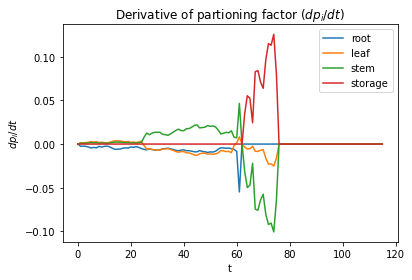

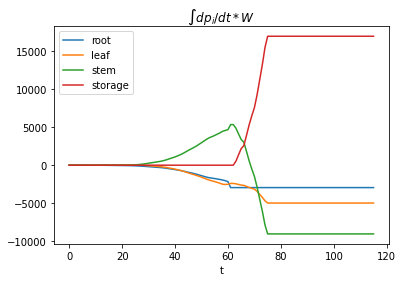

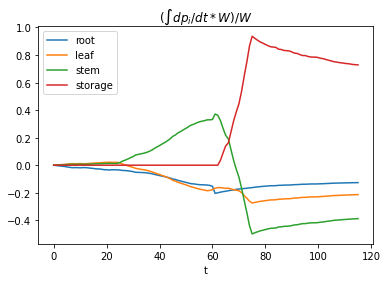

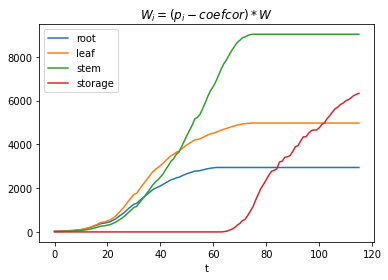

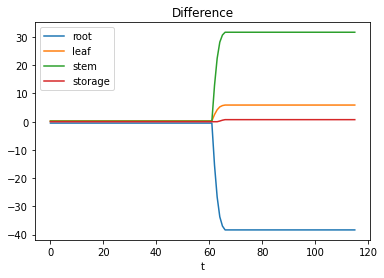

In [351]:
## Trying to debug the partitioning factor
# Plot d p_i/dt
derv = []
for i in organs:
    diff = np.zeros(len(wo_weight))
    diff[1:] = np.diff(pf(i, wo_all))
    derv.append(diff)
    
for k in range(4):
    plt.plot(derv[k], label=organs[k])
plt.legend()
plt.title('Derivative of partioning factor ($d p_i / dt$)')
plt.ylabel('$d p_i / dt$')
plt.xlabel('t')
plt.show()

# Plot \int d_pi/dt * w(t)
int_derv = [0]*4
for i in range(4):
    int_derv[i] = (derv[i] * wo_weight).cumsum()
    plt.plot(int_derv[i], label=organs[i])
plt.legend()
plt.title('$\int d p_i/ dt * W$')
plt.xlabel('t')
plt.show()

# Plot \int d_pi/dt * w(t) / w(t)
coef_cor = [0]*4
for i in range(4):
    coef_cor[i] = int_derv[i] / wo_weight
    plt.plot(coef_cor[i], label=organs[i])
plt.legend()
plt.title('$(\int d p_i/ dt * W) / W $')
plt.xlabel('t')
plt.show()

# Plot (p_i - coef_cor) * W 
p_corrected = [0]*4
for i in range(4):
    p_corrected[i] = pf(organs[i], wo_all) - coef_cor[i]
    plt.plot(p_corrected[i] * wo_weight, label=organs[i])
plt.legend()
plt.xlabel('t')
plt.title('$W_i = (p_i - coef cor) * W$')
plt.show()

# Plot against true weights
true_organ_weights = [wo_all.TWRT, wo_all.TWLV, wo_all.TWST, wo_all.TWSO]
for i in range(4):
    plt.plot(p_corrected[i] * wo_weight - true_organ_weights[i], label=organs[i])
plt.legend()
plt.xlabel('t')
plt.title('Difference')
plt.show()

In [283]:
# plt.plot(wo_all.TWRT, label='Wofost TWRT')
# plt.plot(wo_all.TWLV, label='Wofost TWLV')
# plt.plot(wo_all.TWST, label='Wofost TWST')
# plt.plot(wo_all.TWSO, label='Wofost TWSO')
# plt.xlabel('t')
# plt.ylabel('Organ Weight')
# plt.title('Organ Weight')
# plt.legend()

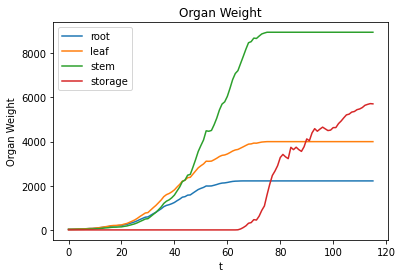

In [28]:
for organ in organs:
    plt.plot(partition_organ(organ, W, wo_all), label=f'{organ}')
plt.xlabel('t')
plt.ylabel('Organ Weight')
plt.title('Organ Weight')
plt.legend()

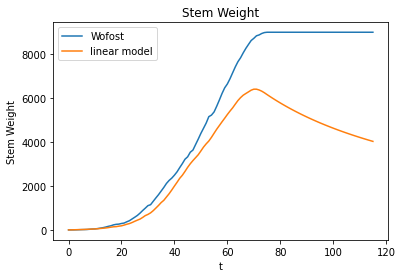

In [124]:
plt.plot(wo_all.TWST, label='Wofost')
plt.plot(W * cum_pf('stem', wo_all) , label='linear model')

# plt.plot(W * pf('stem', wo_all).cumsum() , label='linear model')
# plt.plot((wo_all.TAGP + wo_all.TWRT) * pf('stem', wo_all) , label='linear model')

plt.xlabel('t')
plt.ylabel('Stem Weight')
plt.title('Stem Weight')
plt.legend()

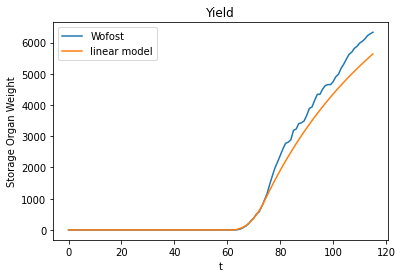

In [125]:
plt.plot(wo_all.TWSO, label='Wofost')
plt.plot(W * cum_pf('storage', wo_all) , label='linear model')
plt.xlabel('t')
plt.ylabel('Storage Organ Weight')
plt.title('Yield')
plt.legend()

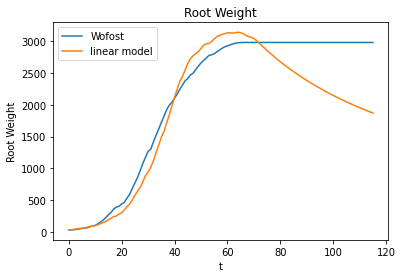

In [126]:
plt.plot(wo_all.TWRT, label='Wofost')
plt.plot(W * cum_pf('root', wo_all) , label='linear model')
plt.xlabel('t')
plt.ylabel('Root Weight')
plt.title('Root Weight')
plt.legend()

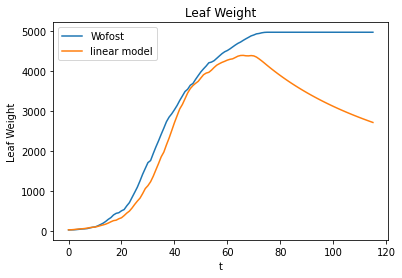

In [127]:
plt.plot(wo_all.TWLV, label='Wofost')
plt.plot(W * cum_pf('leaf', wo_all) , label='linear model')
plt.xlabel('t')
plt.ylabel('Leaf Weight')
plt.title('Leaf Weight')
plt.legend()

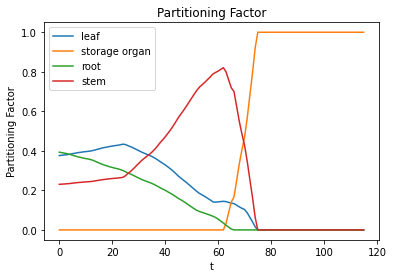

In [456]:
plt.plot(pf('leaf', wo_all) , label='leaf')
plt.plot(pf('storage', wo_all) , label='storage organ')
plt.plot(pf('root', wo_all) , label='root')
plt.plot(pf('stem', wo_all) , label='stem')

plt.xlabel('t')
plt.ylabel('Partitioning Factor')
plt.title('Partitioning Factor')
plt.legend()

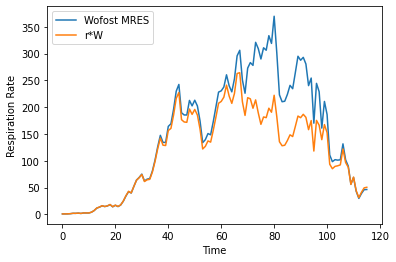

In [445]:
# Respiration rate coefficients
r = coef_resp(wo_all)
plt.plot(wo_all.MRES, label='Wofost MRES')
plt.plot(r * (wo_all.TAGP + wo_all.TWRT), label='r*W')
plt.xlabel('Time')
plt.ylabel('Respiration Rate')
plt.legend()
plt.show()

# f, g = get_f_and_g(wo_all)
# W0 = 50.0 
# W = explicit_solution(wo_all.CVF, W0, f, g, r)
# plt.plot(W)
# plt.plot(wo_all.TAGP)


<ipython-input-386-ea1e909a1501>:31: RuntimeWarning: invalid value encountered in true_divide
  FGRSUN = wo.AMAX * (1 - (wo.AMAX ) * ((1 - np.exp(-wo.VISPP * wo.EFF / wo.AMAX)) / (wo.VISPP * wo.EFF)))
<ipython-input-389-85defcbe711a>:4: RuntimeWarning: invalid value encountered in true_divide
  u = g + f * wo_all.TWLV / pf('leaf', wo_all) # unit assim rate = FGL


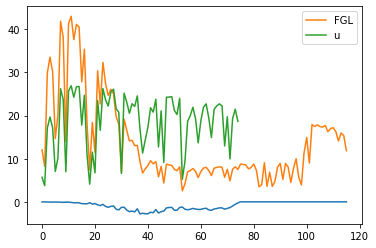

In [389]:
# Gross assimilation rate
f, g = get_f_and_g(wo_all)
k = get_k(wo_all)
u = g + f * wo_all.TWLV / pf('leaf', wo_all) # unit assim rate = FGL
plt.plot(wo_all.FGL, label='FGL')
plt.plot(u, label='u')

plt.legend()
# plt.plot(wo_all.GASS, label='Wofost GASS')
CR = 30./44
gass = u * wo_all.RFTRA * CR * wo_all.DAYL * wo_all.LAI

# def approx_simulation(wo, level=LEVEL):
#     LAI =  leaf_area_index(wo.SLAT, wo.TWLV) # Here TWLV needs to be our computed Weight! 
#     VISSHD = light_shaded(wo.KDIF, wo.PARDIF, LAI, level)
#     FGRSH = assim_shaded(VISSHD, wo.EFF)
#     FGRSUN = assim_sunlit(wo.AMAX, FGRSH, wo.VISPP, wo.EFF)
#     FSLLA = ratio_sunlit(wo.KDIRBL, LAI)
#     FGL = unit_assim(FSLLA, FGRSUN, FGRSH)
#     return FGL

# def get_gass(wo, level=LEVEL):
#     LAI = leaf_area_index(wo.SLAT, wo.TWLV)
#     CR = 30./44. # conversion coefficient (from chemical equation)
#     unit_assim_rate = approx_simulation(wo, level)
#     GASS = wo.RFTRA * CR * wo.DAYL * LAI * unit_assim_rate
#     return GASS 
# plt.show()
# plt.plot(f, label='check')
# plt.xlabel('Time')
# # plt.ylabel('Respiration Rate')
# plt.legend()
# plt.show()

In [290]:
W0 = 50.0 
W = explicit_solution(wo_all.CVF, W0, f, r)
plt.plot(W)
# plt.plot(wo_all.TAGP)

TypeError: explicit_solution() missing 1 required positional argument: 'r'

In [244]:
wo_all.CVF

array([0.67863516, 0.67858848, 0.67854436, 0.67849601, 0.67843388,
       0.67835035, 0.67828055, 0.67820057, 0.67815276, 0.67808826,
       0.67804073, 0.67799901, 0.67793914, 0.67785199, 0.67774022,
       0.67763304, 0.67752838, 0.67744155, 0.67736258, 0.67727942,
       0.6772186 , 0.6771506 , 0.6770971 , 0.67702592, 0.67693128,
       0.67669333, 0.67634548, 0.67605062, 0.67570998, 0.67534159,
       0.6749768 , 0.67460906, 0.67430724, 0.67401717, 0.67374729,
       0.67343636, 0.67307318, 0.67265638, 0.67220471, 0.67179523,
       0.67139249, 0.67092911, 0.67046403, 0.66995716, 0.66940137,
       0.66883337, 0.66835525, 0.66786016, 0.66735316, 0.66679902,
       0.66627255, 0.66573243, 0.66522794, 0.66482374, 0.66453137,
       0.66422284, 0.66388585, 0.66356196, 0.66318365, 0.66295836,
       0.66272457, 0.66244616, 0.66216439, 0.66222814, 0.66254332,
       0.66285274, 0.66300084, 0.66389541, 0.66480679, 0.66557867,
       0.66627302, 0.6671865 , 0.66819277, 0.66918516, 0.67029

# Young Plant

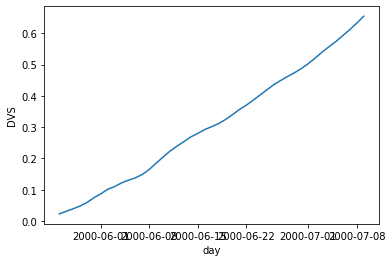

In [399]:
output1 = output[25:70] # 0 < DVS < 1
plot_dynamics(output1, x='day', y='DVS')

In [420]:
# Get coefficients from Wofost
wo = WofostOutput(output1)
PAR = wo.PAR # Incident light
VISPP = wo.VISPP # Direct light absorbed by leaves perpendiculat on direct beam
KDIF = wo.KDIF # Extinction coefficient for diffuse light
KDIRBL = wo.KDIRBL # Extinction coefficient for direct light, completely absorbed by the leaves
EFF = wo.EFF # Light use efficiency
SLAT = wo.SLAT # Specific leaf area 
DAYL = wo.DAYL # Daylength
RFTRA = wo.RFTRA # Reduction factor due to transpiration
CVF = wo.CVF
AMAX = wo.AMAX
CR = 30./44.  # CO2 to CH40 conversion ration
W0 = 50.0 # Initial Weight - TDWI from Crop Parameters
pseudo_SLAT = wo.LAI / wo.TWLV

def pf(plant_organ):
    if plant_organ == 'root':
        return wo.FR
    if plant_organ == 'leaf':
        return wo.FL * (1 - wo.FR)
    if plant_organ == 'stem':
        return wo.FS * (1 - wo.FR)
    if plant_organ == 'storage':
        return wo.FO * (1 - wo.FR)
    else:
        return None 
    
def coef_resp(wo):
    coef_r = wo.RMR * pf('root')
    coef_l = wo.RML * pf('leaf')
    coef_s = wo.RMS * pf('stem')
    coef_o = wo.RMO * pf('storage')
    coef_res = coef_r + coef_l + coef_s + coef_o
    return wo.RFSETB * wo.TEFF * coef_res

def linear_assim():
    return EFF * VISPP * KDIF # Linear part of photosynthesis-light curve

def concise_assim():
    return AMAX * (VISPP * EFF / (VISPP * EFF + AMAX))

# Respiration rate coefficients
r = coef_resp(wo)

# Assimilation rate coefficients
assim_model = linear_assim()
assim_rate = RFTRA * CR * DAYL * assim_model # * LAI, where LAI = W_leaves * SLAT
f = assim_rate * SLAT * pf('leaf')


In [421]:
# Explicit Solution
q = CVF * (f - r)
integral = q.cumsum()
w = W0 * np.exp(integral)
# plt.plot(integral)

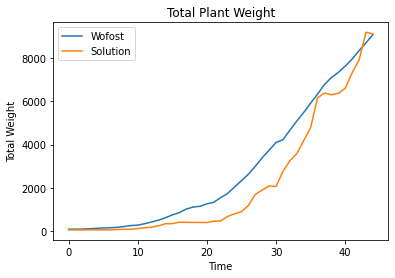

In [422]:
plt.title('Total Plant Weight')
plt.plot(wo.TAGP + wo.TWRT, label='Wofost')
plt.plot(w, label='Solution')
plt.ylabel('Total Weight')
plt.xlabel('Time')
plt.legend()

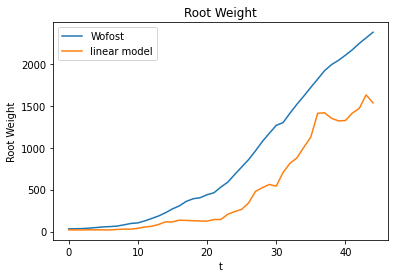

In [423]:
plt.plot(wo.TWRT, label='Wofost')
plt.plot(w * pf('root') , label='linear model')
plt.xlabel('t')
plt.ylabel('Root Weight')
plt.title('Root Weight')
plt.legend()

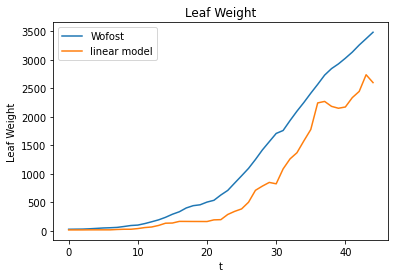

In [424]:
plt.plot(wo.TWLV, label='Wofost')
plt.plot(w * pf('leaf') , label='linear model')
plt.xlabel('t')
plt.ylabel('Leaf Weight')
plt.title('Leaf Weight')
plt.legend()

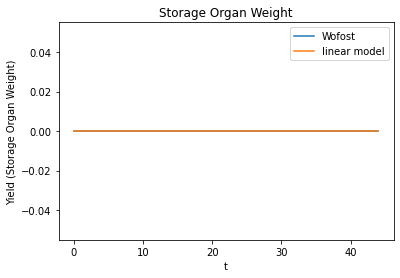

In [425]:
plt.plot(wo.TWSO, label='Wofost')
plt.plot(w * pf('storage') , label='linear model')
plt.xlabel('t')
plt.ylabel('Yield (Storage Organ Weight)')
plt.title('Storage Organ Weight')
plt.legend()

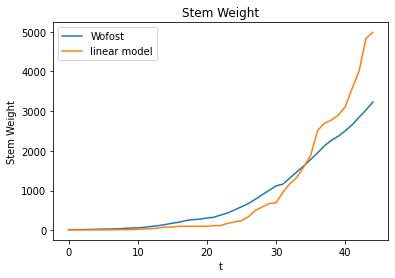

In [426]:
plt.plot(wo.TWST, label='Wofost')
plt.plot(w * pf('stem') , label='linear model')
plt.xlabel('t')
plt.ylabel('Stem Weight')
plt.title('Stem Weight')
plt.legend()

# Iterative Solution

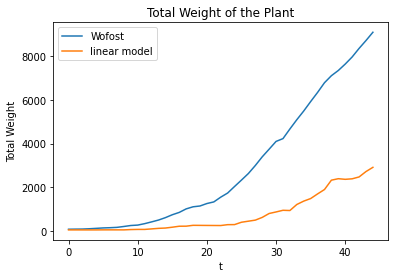

In [427]:
# Iteratively: Add delta W, instead of exponential
T = len(output1)
w2 = np.zeros(T)
w2[0] = W0
dw = np.zeros(T)

for t in range(0, T-1):
    dw[t+1] = w2[t] * CVF[t] * (f[t] - r[t])
    w2[t+1] = w2[t] + dw[t]

plt.plot(wo.TAGP + wo.TWRT, label='Wofost')
plt.plot(w2, label='linear model')
plt.xlabel('t')
plt.ylabel('Total Weight')
plt.title('Total Weight of the Plant')
plt.legend()

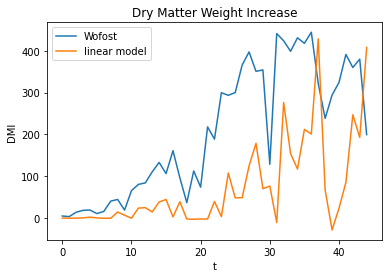

In [428]:
plt.plot(wo.DMI, label='Wofost')
plt.plot(dw, label='linear model')
plt.xlabel('t')
plt.ylabel('DMI')
plt.title('Dry Matter Weight Increase')
plt.legend()

# Mature Plant

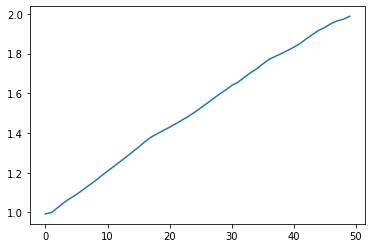

In [441]:
wo0 = WofostOutput(output)
# plt.plot(wo0.DVS)
output2 = output[90:140] # 1 < DVS < 2
wo = WofostOutput(output2)
plt.plot(wo2.DVS)

In [652]:
# Get coefficients from Wofost
wo = WofostOutput(output2)
PAR = wo.PAR # Incident light
VISPP = wo.VISPP # Direct light absorbed by leaves perpendiculat on direct beam
VISSHD = wo.VISSHD # Diffuse light absorbed by shaded leaves
KDIF = wo.KDIF # Extinction coefficient for diffuse light
KDIRBL = wo.KDIRBL # Extinction coefficient for direct light, completely absorbed by the leaves
EFF = wo.EFF # Light use efficiency
SLAT = wo.SLAT # Specific leaf area 
DAYL = wo.DAYL # Daylength
RFTRA = wo.RFTRA # Reduction factor due to transpiration
CVF = wo.CVF
AMAX = wo.AMAX
CR = 30./44.  # CO2 to CH40 conversion ration
W0 = wo.TAGP[0] + wo.TWRT[0] # Start from the correct weight

def pf(plant_organ):
    if plant_organ == 'root':
        return wo.FR
    if plant_organ == 'leaf':
        return wo.FL * (1 - wo.FR)
    if plant_organ == 'stem':
        return wo.FS * (1 - wo.FR)
    if plant_organ == 'storage':
        return wo.FO * (1 - wo.FR)
    else:
        return None 
    
def coef_resp(wo):
    coef_r = wo.RMR * pf('root')
    coef_l = wo.RML * pf('leaf')
    coef_s = wo.RMS * pf('stem')
    coef_o = wo.RMO * pf('storage')
    coef_res = coef_r + coef_l + coef_s + coef_o
    return wo.RFSETB * wo.TEFF * coef_res

# Respiration rate coefficients
r = coef_resp(wo)

def linear_assim():
    return EFF * VISSHD # Linear part of photosynthesis-light curve

def constant_assim(): # Light saturation
    return AMAX 

def concise_assim():
    return AMAX * (VISPP * EFF / (VISPP * EFF + AMAX))

# Assimilation rate coefficients
assim_model = concise_assim()
assim_rate = RFTRA * CR * DAYL * assim_model # * LAI, where LAI = W_leaves * SLAT
f = assim_rate * SLAT * pf('leaf')
g = RFTRA * CR * DAYL * constant_assim() #* SLAT * pf('leaf')

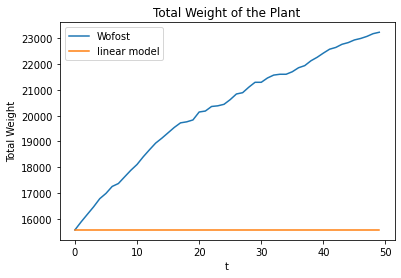

In [653]:
# Use the model from Young Plant and use VISSHD instead
assim_rate = RFTRA * CR * DAYL * linear_assim() # * LAI, where LAI = W_leaves * SLAT
f = assim_rate * SLAT * pf('leaf')
q = CVF * np.where((f - r) > 0, (f - r), 0)
integral = q.cumsum()
w = W0 * np.exp(integral)

plt.plot(wo.TAGP + wo.TWRT, label='Wofost')
plt.plot(w, label='linear model')
plt.xlabel('t')
plt.ylabel('Total Weight')
plt.title('Total Weight of the Plant')
plt.legend()

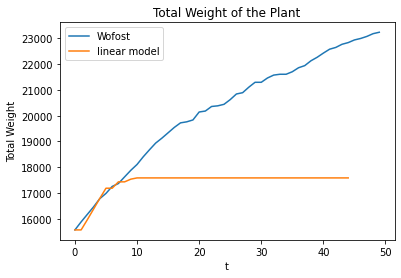

In [611]:
# Iteratively: Add delta W, instead of exponential
T = len(output1)
w2 = np.zeros(T)
w2[0] = W0
dw = np.zeros(T)

for t in range(0, T-1):
    dw[t+1] = w2[t] * CVF[t] * max(0, (f[t] - r[t]))
    w2[t+1] = w2[t] + dw[t]

plt.plot(wo.TAGP + wo.TWRT, label='Wofost')
plt.plot(w2, label='linear model')
plt.xlabel('t')
plt.ylabel('Total Weight')
plt.title('Total Weight of the Plant')
plt.legend()

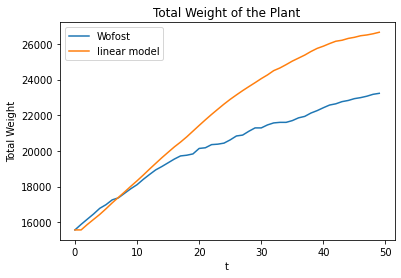

In [614]:
# Iteratively: Add delta W, instead of exponential
T = len(output2)
w2 = np.zeros(T)
w2[0] = W0
dw = np.zeros(T)

for t in range(0, T-1):
    dw[t+1] = CVF[t] * max(0, (g[t] - r[t]*w2[t]))
    w2[t+1] = w2[t] + dw[t]

plt.plot(wo.TAGP + wo.TWRT, label='Wofost')
plt.plot(w2, label='linear model')
plt.xlabel('t')
plt.ylabel('Total Weight')
plt.title('Total Weight of the Plant')
plt.legend()

In [655]:
# plt.plot(wo.TWSO, label='Wofost')
# plt.plot(w2 * pf('storage') , label='linear model')
# plt.xlabel('t')
# plt.ylabel('Yield (Storage Organ Weight)')
# plt.title('Storage Organ Weight')
# plt.legend()

In [656]:
# plt.plot(wo.TWST, label='Wofost')
# plt.plot(w2 * pf('stem') , label='linear model')
# plt.xlabel('t')
# plt.ylabel('Stem Weight')
# plt.title('Stem Weight')
# plt.legend()

In [657]:
# plt.plot(wo.TWLV, label='Wofost')
# plt.plot(w2 * pf('leaf') , label='linear model')
# plt.xlabel('t')
# plt.ylabel('Leaf Weight')
# plt.title('Leaf Weight')
# plt.legend()

In [658]:
# plt.plot(wo.TWRT, label='Wofost')
# plt.plot(w2 * pf('root') , label='linear model')
# plt.xlabel('t')
# plt.ylabel('Root Weight')
# plt.title('Root Weight')
# plt.legend()

In [659]:
# AMAX

array([70.        , 70.        , 70.        , 70.        , 70.        ,
       70.        , 70.        , 70.        , 70.        , 70.        ,
       70.        , 70.        , 69.84632391, 69.18015424, 68.4729563 ,
       67.44917178, 67.0348072 , 66.38735219, 65.89825193, 65.43974293,
       64.97943445, 64.49285347, 63.96848329, 63.45994859, 62.77758355,
       61.51794344, 60.26118252, 58.95547558, 57.65840617, 56.48658098,
       55.19383033, 54.2818509 , 52.94807198, 51.64452442, 50.49645244,
       49.13028278, 46.66642674, 44.9777892 , 43.40143959, 41.65089974,
       39.7851928 , 37.78128535, 35.08061697, 32.67794344, 30.29974293,
       28.67012853, 26.22603999, 19.6425572 , 23.9914653 , 22.3618509 ])

In [587]:
# r[t]*w2[t]

60.13148565220733

In [603]:
# # Explicit Solution 1 
# q = CVF * (f - r)
# q2 = np.where(q < 0, 0, q)
# integral = q2.cumsum()
# w = W0 * np.exp(integral)
# plt.plot(integral)

In [604]:
# plt.title('Total Plant Weight')
# plt.plot(wo.TAGP + wo.TWRT, label='Wofost')
# plt.plot(w, label='Solution')
# plt.ylabel('Total Weight')
# plt.xlabel('Time')
# plt.legend()

In [660]:
# r2 = np.where(r < g, r, g)
# integral = r2.cumsum()
# plt.plot(integral)
# w = (g - g[0] * np.exp(-integral)) / r2
# g[0]
# # w = (g - g[0] * np.exp(-integral)) / r

In [661]:
# plt.title('Total Plant Weight')
# plt.plot(wo.TAGP + wo.TWRT, label='Wofost')
# plt.plot(w, label='Solution')
# plt.ylabel('Total Weight')
# plt.xlabel('Time')
# plt.legend()